In [60]:
import pandas as pd
import networkx as nx
import numpy as np

# Read in the CSV files

# 0.1%
#accounts_df = pd.read_csv("../datasets/p_0_1_percent/PS_20230505183351_53313/PS_20230505183351_53313_account_attributes.csv")
#transactions_df = pd.read_csv("../datasets/p_0_1_percent/PS_20230505183351_53313/PS_20230505183351_53313_rawLog.csv")

# 0.5%
accounts_df = pd.read_csv("../datasets/p_0_5_percent/PS_20230509175835_53313/PS_20230509175835_53313_account_attributes.csv")
transactions_df = pd.read_csv("../datasets/p_0_5_percent/PS_20230509175835_53313/PS_20230509175835_53313_rawLog.csv")

# 1%
#accounts_df = pd.read_csv("../datasets/p_1_percent/PS_20230509180228_53313/PS_20230509180228_53313_account_attributes.csv")
#transactions_df = pd.read_csv("../datasets/p_1_percent/PS_20230509180228_53313/PS_20230509180228_53313_rawLog.csv")

# 5%
#accounts_df = pd.read_csv("../datasets/p_5_percent/PS_20230509180753_53313/PS_20230509180753_53313_account_attributes.csv")
#transactions_df = pd.read_csv("../datasets/p_5_percent/PS_20230509180753_53313/PS_20230509180753_53313_rawLog.csv")





In [61]:
nodes_df = accounts_df
edges_df = transactions_df


nodes_df.head()
edges_df.head()

,step,action,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,isUnauthorizedOverdraft
0,0,TRANSFER,144926.15,C4188622926,144926.15,0.0,CC5817260722,0.0,144926.15,1,0,0
1,0,CASH_OUT,144926.15,CC5817260722,144926.15,0.0,M7094476463,0.0,0.00,1,0,0
2,0,TRANSFER,38.58,C0545086345,38.58,0.0,CC2966082992,0.0,38.58,1,0,0
3,0,CASH_OUT,38.58,CC2966082992,38.58,0.0,M3892452657,0.0,0.00,1,0,0
4,0,TRANSFER,71.81,C6926636176,71.81,0.0,CC9880115251,0.0,71.81,1,0,0


In [62]:
# create dummies for the 'action' column
dummies = pd.get_dummies(edges_df.action, prefix='action')

# concatenate the dummies to the original DataFrame
edges_df = pd.concat([edges_df, dummies], axis=1)

# drop the original 'action' column
edges_df.drop('action', axis=1, inplace=True)

edges_df.head()

,step,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,isUnauthorizedOverdraft,action_CASH_IN,action_CASH_OUT,action_DEBIT,action_PAYMENT,action_TRANSFER
0,0,144926.15,C4188622926,144926.15,0.0,CC5817260722,0.0,144926.15,1,0,0,False,False,False,False,True
1,0,144926.15,CC5817260722,144926.15,0.0,M7094476463,0.0,0.00,1,0,0,False,True,False,False,False
2,0,38.58,C0545086345,38.58,0.0,CC2966082992,0.0,38.58,1,0,0,False,False,False,False,True
3,0,38.58,CC2966082992,38.58,0.0,M3892452657,0.0,0.00,1,0,0,False,True,False,False,False
4,0,71.81,C6926636176,71.81,0.0,CC9880115251,0.0,71.81,1,0,0,False,False,False,False,True


In [63]:
# Now we compute numerical indices for nameOrig and nameDest rather than their form 'CC6839167080'

# Create a dictionary that maps each unique original name to a new unique ID
node_ids = {node_name: i for i, node_name in enumerate(set(edges_df['nameOrig']).union(set(edges_df['nameDest'])))}


# Replace the original names with the new IDs
edges_df['nameOrig'] = edges_df['nameOrig'].map(node_ids)
edges_df['nameDest'] = edges_df['nameDest'].map(node_ids)

edges_df.head()

,step,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,isUnauthorizedOverdraft,action_CASH_IN,action_CASH_OUT,action_DEBIT,action_PAYMENT,action_TRANSFER
0,0,144926.15,8545,144926.15,0.0,38019,0.0,144926.15,1,0,0,False,False,False,False,True
1,0,144926.15,38019,144926.15,0.0,38186,0.0,0.00,1,0,0,False,True,False,False,False
2,0,38.58,19321,38.58,0.0,6738,0.0,38.58,1,0,0,False,False,False,False,True
3,0,38.58,6738,38.58,0.0,25158,0.0,0.00,1,0,0,False,True,False,False,False
4,0,71.81,18839,71.81,0.0,51085,0.0,71.81,1,0,0,False,False,False,False,True


In [64]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.transforms import NormalizeFeatures

def visualize(h, color):
    z = TSNE(n_components=2, learning_rate='auto',
             init='random').fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

def print_model_size(model):
    tot = sum([p.numel() for p in model.parameters() if p.requires_grad])
    out = f"Number of model ({model.__class__.__name__}) parameters:{tot:10d}"
    print("=" * len(out))
    print(out)

2.0.1+cu118


In [65]:
x_np = nodes_df.to_numpy()
x = x_np[:,0:-3]
x.shape

(58246, 41)

In [66]:
from torch.utils.data import random_split
# Define your graph
x = torch.nn.functional.normalize(torch.tensor(x),dim=0).to(torch.float32)  # (n x features)
edge_index =  torch.stack([torch.tensor(edges_df.nameOrig.to_numpy()),torch.tensor(edges_df.nameDest.to_numpy())],dim=-1).T  # Define your edge index
edge_attr = torch.nn.functional.normalize(torch.tensor(np.array(edges_df[['amount','oldBalanceOrig', 'newBalanceOrig', 'oldBalanceDest', 'newBalanceDest','isFlaggedFraud','isUnauthorizedOverdraft','action_CASH_IN','action_CASH_OUT','action_DEBIT','action_PAYMENT','action_TRANSFER']].values,dtype='float32')),dim=0) # edge features
y =  torch.tensor(nodes_df.node_isFraud.to_numpy().astype(int),dtype=torch.long) # target values

# Bitflip the tensor
#y = y ^ torch.tensor([1], dtype=torch.uint8).expand_as(y)


train_size = int(0.6 * len(y))  # 60% of the dataset for training
val_size = int(0.2 * len(y))    # 20% of the dataset for validation
test_size = len(y) - train_size - val_size  # Remaining 20% for testing

train_dataset, val_dataset, test_dataset = random_split(y, [train_size, val_size, test_size])

# Create masks for train, validation, and test sets
train_mask = torch.zeros(len(y), dtype=torch.bool)
val_mask = torch.zeros(len(y), dtype=torch.bool)
test_mask = torch.zeros(len(y), dtype=torch.bool)

train_mask[train_dataset.indices] = True
val_mask[val_dataset.indices] = True
test_mask[test_dataset.indices] = True

In [67]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [68]:
from torch_geometric.data import Data
# Load your data into PyTorch Geometric's Data class
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y,train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
data.to(device)

Data(x=[58246, 41], edge_index=[2, 3788383], edge_attr=[3788383, 12], y=[58246], train_mask=[58246], val_mask=[58246], test_mask=[58246])

In [69]:
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

print('==============================')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Is weighted: {data.edge_weight is not None}')

print('==============================')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')

Number of nodes: 58246
Number of edges: 3788383
Average node degree: 65.04
Has isolated nodes: False
Has self-loops: False
Is undirected: False
Is weighted: False
Number of training nodes: 34947
Training node label rate: 0.60


In [70]:
from models.MPNN import GNN_MPNN_Model
from models.SAGE import GNN_SAGE_Model
from models.CONV import GNN_CONV_Model
from torch_geometric.nn import Sequential, GAT, GIN

In [97]:
HIDDEN_SIZE = 16 #@param
NUM_LAYERS = 2 #@param

dataset_num_features = x.size()[1]
dataset_num_classes = 2

# Message Passing Neural Network
model = GNN_MPNN_Model(hidden_size=HIDDEN_SIZE, input_size=dataset_num_features, output_size= dataset_num_classes, num_layers=NUM_LAYERS)

# GraphSAGE
#model = GNN_SAGE_Model(hidden_size=HIDDEN_SIZE, input_size=dataset_num_features, output_size= dataset_num_classes, num_layers=NUM_LAYERS)

# CONV
#model = GNN_CONV_Model(hidden_size=HIDDEN_SIZE, input_size=dataset_num_features, output_size= dataset_num_classes, num_layers=NUM_LAYERS)

# GAT
#model = GAT(in_channels=dataset_num_features, hidden_channels=HIDDEN_SIZE, num_layers=NUM_LAYERS, out_channels=dataset_num_features)

# GIN
#model = GIN(in_channels=dataset_num_features, hidden_channels=HIDDEN_SIZE, num_layers=NUM_LAYERS, out_channels=dataset_num_features)

model.to(device)
model.eval()

out = model(data.x, data.edge_index)
#visualize(out, color=data.y)

In [98]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 100})'''))

criterion = torch.nn.CrossEntropyLoss()
#criterion = CrossEntropyFocalLoss(gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
      model.train()
      optimizer.zero_grad()
      # We now give as input also the graph connectivity
      out = model(data.x, data.edge_index)
      #print(len(out[data.train_mask]),len(data.y[data.train_mask]))
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      #loss = sigmoid_focal_loss(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[mask] == data.y[mask]
      test_acc = int(test_correct.sum()) / int(mask.sum())
      test_out = out[mask]
      test_pred = pred[mask]
      return test_acc, test_out, test_pred

#print("epoch,train_loss,validation_loss")
st = time.time()
for epoch in range(1, 401):
    train_loss = train()
    val_loss, _, _ = test(data.val_mask)
    
    #print(f'Epoch: {epoch:03d} - Training loss: {train_loss:.4f} - ' f'Validation accuracy: {val_loss * 100:.2f}%')
    print(str(epoch) + ',' + str(train_loss.item()) + ',' + str(val_loss*100) + ';')
et = time.time()
elapsed_time = et - st


<IPython.core.display.Javascript object>

1,0.6643536686897278,93.96514722293759;
2,0.6125590205192566,93.96514722293759;
3,0.5679193139076233,93.96514722293759;
4,0.5279111862182617,93.96514722293759;
5,0.48981398344039917,93.96514722293759;
6,0.45190852880477905,93.96514722293759;
7,0.41368868947029114,93.96514722293759;
8,0.3756135404109955,93.96514722293759;
9,0.33883121609687805,93.96514722293759;
10,0.3049149513244629,93.96514722293759;
11,0.2755413055419922,93.96514722293759;
12,0.25210753083229065,93.96514722293759;
13,0.23537997901439667,93.96514722293759;
14,0.22529877722263336,93.96514722293759;
15,0.22101719677448273,93.96514722293759;
16,0.22115495800971985,93.96514722293759;
17,0.22414445877075195,93.96514722293759;
18,0.22853757441043854,93.96514722293759;
19,0.23319293558597565,93.96514722293759;
20,0.23733028769493103,93.96514722293759;
21,0.24049313366413116,93.96514722293759;
22,0.2424737811088562,93.96514722293759;
23,0.24323950707912445,93.96514722293759;
24,0.2428727149963379,93.96514722293759;
25,0.24152

In [99]:
print("Time for", epoch, "epochs is", elapsed_time, "seconds")

Time for 400 epochs is 14.657184839248657 seconds


In [100]:
def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[mask] == data.y[mask]
      test_acc = int(test_correct.sum()) / int(mask.sum())
      test_out = out[mask]
      test_pred = pred[mask]
      return test_acc, test_out, test_pred

In [104]:
test_acc, test_out, test_pred  = test(data.test_mask)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

Test Accuracy: 97.14%


In [102]:
out = model(data.x, data.edge_index)
#visualize(out, color=data.y)

tensor(379)
tensor(0.0609)
Precision: 1.00
Recall: 0.53
F1-score: 0.69


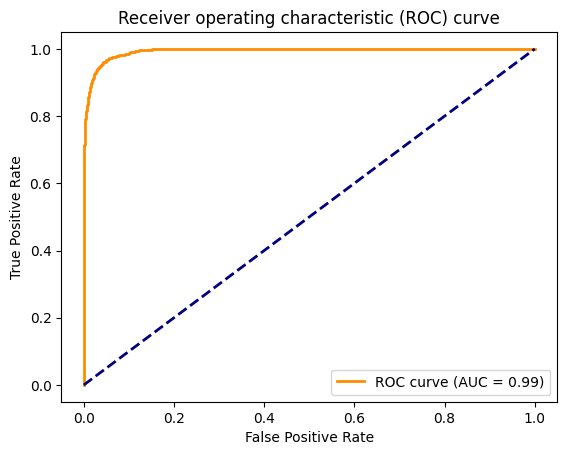

In [103]:
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
import torch.nn.functional as F

y_true = data.y[data.test_mask].cpu()
y_pred = softmax_x = F.softmax(test_out, dim=1)
test_pred = y_pred.argmax(dim=1).detach().cpu()
y_pred = y_pred[:, 1].detach().cpu().numpy()
print(torch.sum(test_pred))
print(torch.sum(y_true)/y_true.shape[0])


# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, test_pred, average='binary')

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1_score))

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [317]:
fpr, tpr, roc_auc

df_model = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
df_model.to_csv('results/_5.csv', index=False)